In [1]:
import cpm
from packaging import version

## cpm checks
print(cpm.__version__)
if version.parse(cpm.__version__) < version.parse("0.22"):
    raise ImportError("cpm version must be >= 0.22. Please install the latest version using: pip install --upgrade cpm")

0.23.0


# EXERCISE 1

In the following exercise, you will implement a model based on the mathematical description, and use the `cpm` toolbox to do so. What will you do here?

1. Build a model of a simple bandit task using the toolbox based on the mathematical description
1. Explore the model's behaviour by varying its parameters

## The model description


Let each stimulus have an associated value, which is the expected reward that can be obtained from selecting that stimulus. Let also $Q(a)$ be the estimated value of action $a$. We set the starting value for all $Q(a)$ to be nonzero and equally distributed between all stimuli.

In each trial, $t$, there are two stimuli present, so $Q(a)$ could be $Q(\text{left})$ or $Q(\text{right})$, where the corresponding Q values are derived from the associated value of the stimuli present on the left or right.
More formally, we can say that the expected value of the action $a$ selected at time $t$ is given by:

\begin{equation}
Q_t(a) = \mathbb{E}[R_t | A_t = a]
\end{equation}

where $R_t$ is the reward received at time $t$, and $A_t$ is the action selected at time $t$. In each trial $t$, the Softmax choice rule (Bridle, 1990) will select an action (left or right) based on the following policy:

\begin{equation}
P(a_t) = \frac{e^{Q_{a,t} \beta}}{\sum_{i = 1}^{k}{e^{Q_{i,t} \beta}}}
\end{equation}

where $\beta$ is the inverse temperature parameter, also referred to as choice stochasticity, and $Q_{a,t}$ is the estimated value of the action $a$ at time $t$. $k$ is the number of actions available, and in our case, $k = 2$. The model uses the variant of the delta rule (Rescorla & Wagner, 1972; Rumelhart, Hinton & Williams, 1986) adapted for multi-armed bandit problems where each option has a single dimension (Barto & Sutton, 2018), reducing Rescorla-Wagner's summed error-term to the following equation, similar to single linear operators (Bush and Mosteller, 1955):


\begin{equation}
\Delta Q_t(A_t) = \alpha \times \Big[ R_t - Q_t(A_t) \Big]
\end{equation}


where $\alpha$ is the learning rate and $R_t$ is the reward received at time $t$, also called a teaching signal and sometimes annotated as $\lambda$. $A_t$ is the action chosen for the trial $t$. Then we update the Q-values, such as:

\begin{equation}
Q_{t+1}(A_t) = Q_t(A_t) + \Delta Q_t(A_t)
\end{equation}

## EXERCISE 1.1: build your model

Your task here will be to implement the model described above using the `cpm` toolbox. Fortunately, most of the code is already here, so you will only need to fill in the blanks.

First, let us look at the data.

In [2]:
import cpm.datasets as datasets

data = datasets.load_bandit_data()
data.head()

,ppt,trial,arm_left,arm_right,reward_left,reward_right,response,feedback
0,1,1,2,4,1,1,0,1
1,1,2,2,4,1,1,1,1
2,1,3,2,1,0,0,0,0
3,1,4,2,1,0,0,1,0
4,1,5,1,4,0,0,0,0


The model will process each trial in the data, so below we can actually see what the model is going to see when it is run:

In [3]:
data.iloc[0]

ppt             1
trial           1
arm_left        2
arm_right       4
reward_left     1
reward_right    1
response        0
feedback        1
Name: 0, dtype: int64

Now let's start by the model parameters. Specify each model parameter, their respective priors, and the initial values. The model parameters are:
- `alpha`: the learning rate
- `beta`: the inverse temperature parameter
- `Q`: the initial Q-values for each action (not a free parameter, but a model state)

In [4]:
from cpm.generators import Parameters, Value
import numpy
import pandas as pd

parameters = Parameters(
    # free parameters are indicated by specifying priors
    alpha=Value(
        value=0.5,
        lower=1e-10,
        upper=1,
        prior="truncated_normal",
        args={"mean": 0.5, "sd": 0.25},
    ),
    temperature=Value(
        value=1,
        lower=0,
        upper=10,
        prior="truncated_normal",
        args={"mean": 5, "sd": 2.5},
    ),
    # everything without a prior is part of the initial state of the
    # model or constructs fixed throughout the simulation
    # (e.g. exemplars in general-context models of categorizations)
    # initial q-values starting starting from non-zero value
    # these are equal to all 4 stimuli (1 / 4)
    values = numpy.array([0.25, 0.25, 0.25, 0.25])
    )

In [9]:
import cpm
import ipyparallel as ipp  ## for parallel computing with ipython (specific for Jupyter Notebook)

@ipp.require("numpy")
def model(parameters, trial):
    # pull out the parameters
    alpha = parameters.alpha
    temperature = parameters.temperature
    values = numpy.array(parameters.values)
    
    # pull out the trial information
    stimulus = numpy.array([trial.arm_left, trial.arm_right]).astype(int)
    feedback = numpy.array([trial.reward_left, trial.reward_right])
    human_choice = trial.response.astype(int)

    # Equation 1. - get the value of each available action
    # Note that because python counts from 0, we need to shift
    # the stimulus identifiers by -1
    expected_rewards = values[stimulus - 1]
    # convert columns to rows
    expected_rewards = expected_rewards.reshape(2, 1)
    # calculate a policy based on the activations
    # Equation 2.
    choice_rule = cpm.models.decision.Softmax(
        activations=expected_rewards,
        temperature=temperature
        )
    choice_rule.compute() # compute the policy
    # if the policy is NaN for an action, then we need to set it to 1
    # this corrects some numerical issues with python and infinities
    if numpy.isnan(choice_rule.policies).any():
        choice_rule.policies[numpy.isnan(choice_rule.policies)] = 1
    # get the received reward for the choice
    reward = feedback[human_choice]
    teacher = numpy.array([reward])
    # we now create a vector that tells our learning rule what...
    # ... stimulus to update according to the participant's choice
    what_to_update = numpy.zeros(4)
    chosen_stimulus = stimulus[human_choice] - 1
    what_to_update[chosen_stimulus] = 1

    # Equation 4.
    update = cpm.models.learning.SeparableRule(
                    weights=values,
                    feedback=teacher,
                    input=what_to_update,
                    alpha=alpha
                    )
    update.compute()
    # Equation 5.
    values += update.weights.flatten()
    # compile output
    output = {
        "trial"    : trial.trial.astype(int), # trial numbers
        "activation" : expected_rewards.flatten(), # expected reward of arms
        "policy"   : choice_rule.policies,       # policies
        "reward"   : reward,                  # received reward
        "error"    : update.weights,          # prediction error
        "values"   : values,                  # updated values
        # dependent variable
        "dependent"  : numpy.array([choice_rule.policies[1]]),
    }
    return output

One important thing to note is that the model requires to output a variable called `dependent_variable`, which is the prediction we wish to compare to observations. Once you filled in the blanks, you can run the model and see how it performs on the data:

In [10]:
model(parameters, data.iloc[0])

{'trial': 1,
 'activation': array([0.25, 0.25]),
 'policy': array([0.5, 0.5]),
 'reward': 1,
 'error': array([[0.   , 0.375, 0.   , 0.   ]]),
 'values': array([0.25 , 0.625, 0.25 , 0.25 ]),
 'dependent': array([0.5])}

## EXERCISE 1.2: run your model with different parameters and explore its behaviour

Here, we will see how the model behaves with different parameters. You can change the values of `alpha` and `beta` to see how they affect the model's predictions.

In [11]:
from cpm.generators import Simulator, Wrapper

wrapper = Wrapper(model=model, parameters=parameters, data=data[data.ppt == 1])
wrapper.run()
wrapper.export()

,trial_0,activation_0,activation_1,policy_0,policy_1,reward_0,error_0,error_1,error_2,error_3,values_0,values_1,values_2,values_3,dependent_0,ppt
0,1,0.250000,0.250000,0.500000,0.500000,1,0.0000,0.375000,0.0,0.000000,0.250000,0.625000,0.250000,0.250000,0.500000,0
1,2,0.625000,0.250000,0.592667,0.407333,1,0.0000,0.000000,0.0,0.375000,0.250000,0.625000,0.250000,0.625000,0.407333,0
2,3,0.625000,0.250000,0.592667,0.407333,0,-0.0000,-0.312500,-0.0,-0.000000,0.250000,0.312500,0.250000,0.625000,0.407333,0
3,4,0.312500,0.250000,0.515620,0.484380,0,-0.1250,-0.000000,-0.0,-0.000000,0.125000,0.312500,0.250000,0.625000,0.484380,0
4,5,0.125000,0.625000,0.377541,0.622459,0,-0.0625,-0.000000,-0.0,-0.000000,0.062500,0.312500,0.250000,0.625000,0.622459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,92,0.751955,0.251221,0.622632,0.377368,1,0.0000,0.374390,0.0,0.000000,0.751955,0.625610,0.464693,0.953123,0.377368,0
92,93,0.625610,0.953123,0.418846,0.581154,1,0.0000,0.000000,0.0,0.023438,0.751955,0.625610,0.464693,0.976562,0.581154,0
93,94,0.751955,0.976562,0.444083,0.555917,0,-0.0000,-0.000000,-0.0,-0.488281,0.751955,0.625610,0.464693,0.488281,0.555917,0
94,95,0.464693,0.488281,0.494103,0.505897,1,0.0000,0.000000,0.0,0.255860,0.751955,0.625610,0.464693,0.744140,0.505897,0


In [12]:
wrapper.reset(parameters={"alpha": 0.1123, "temperature": 7.23334}, data=data[data.ppt == 2])
wrapper.run()
wrapper.export()

,trial_0,activation_0,activation_1,policy_0,policy_1,reward_0,error_0,error_1,error_2,error_3,values_0,values_1,values_2,values_3,dependent_0,ppt
0,1,0.250000,0.250000,0.500000,0.500000,1,0.000000,0.000000,0.000000,0.084225,0.250000,0.250000,0.250000,0.334225,0.500000,0
1,2,0.250000,0.334225,0.352235,0.647765,0,-0.000000,-0.028075,-0.000000,-0.000000,0.250000,0.221925,0.250000,0.334225,0.647765,0
2,3,0.250000,0.221925,0.550595,0.449405,1,0.000000,0.000000,0.084225,0.000000,0.250000,0.221925,0.334225,0.334225,0.449405,0
3,4,0.334225,0.221925,0.692600,0.307400,1,0.000000,0.087378,0.000000,0.000000,0.250000,0.309303,0.334225,0.334225,0.307400,0
4,5,0.334225,0.250000,0.647765,0.352235,0,-0.028075,-0.000000,-0.000000,-0.000000,0.221925,0.309303,0.334225,0.334225,0.352235,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,92,0.059860,0.555964,0.026897,0.973103,1,0.000000,0.000000,0.049865,0.000000,0.059860,0.280095,0.605829,0.770491,0.973103,0
92,93,0.770491,0.059860,0.994178,0.005822,1,0.000000,0.000000,0.000000,0.025774,0.059860,0.280095,0.605829,0.796264,0.005822,0
93,94,0.059860,0.280095,0.168957,0.831043,0,-0.000000,-0.031455,-0.000000,-0.000000,0.059860,0.248640,0.605829,0.796264,0.831043,0
94,95,0.059860,0.248640,0.203345,0.796655,0,-0.006722,-0.000000,-0.000000,-0.000000,0.053137,0.248640,0.605829,0.796264,0.796655,0


## EXERCISE 1.3: run your model with different initial state and explore its behaviour

In [13]:
wrapper.reset(parameters={"values": numpy.array([0.5, 0.1, 0.8, 0.9])}, data=data[data.ppt == 2])
wrapper.run()
wrapper.export()

,trial_0,activation_0,activation_1,policy_0,policy_1,reward_0,error_0,error_1,error_2,error_3,values_0,values_1,values_2,values_3,dependent_0,ppt
0,1,0.100000,0.900000,0.310026,0.689974,1,0.000000,0.000000,0.000000,0.050000,0.500000,0.100000,0.800000,0.950000,0.689974,0
1,2,0.100000,0.950000,0.299433,0.700567,0,-0.000000,-0.050000,-0.000000,-0.000000,0.500000,0.050000,0.800000,0.950000,0.700567,0
2,3,0.800000,0.050000,0.679179,0.320821,1,0.000000,0.000000,0.100000,0.000000,0.500000,0.050000,0.900000,0.950000,0.320821,0
3,4,0.900000,0.050000,0.700567,0.299433,1,0.000000,0.475000,0.000000,0.000000,0.500000,0.525000,0.900000,0.950000,0.299433,0
4,5,0.900000,0.500000,0.598688,0.401312,0,-0.250000,-0.000000,-0.000000,-0.000000,0.250000,0.525000,0.900000,0.950000,0.401312,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,92,0.000122,0.447138,0.390070,0.609930,1,0.000000,0.000000,0.276431,0.000000,0.000122,0.157483,0.723569,0.866208,0.609930,0
92,93,0.866208,0.000122,0.703931,0.296069,1,0.000000,0.000000,0.000000,0.066896,0.000122,0.157483,0.723569,0.933104,0.296069,0
93,94,0.000122,0.157483,0.460741,0.539259,0,-0.000000,-0.078741,-0.000000,-0.000000,0.000122,0.078741,0.723569,0.933104,0.539259,0
94,95,0.000122,0.078741,0.480355,0.519645,0,-0.000061,-0.000000,-0.000000,-0.000000,0.000061,0.078741,0.723569,0.933104,0.519645,0


## Exercise 1.4: plot the model output as a function of change in the learning rate

Pick a range of learning rates and plot the model output as a function of the change in the learning rate. Try to find learning rates that lead to different behaviours of the model.

In [14]:
alpha_not_so_random = numpy.array([0.25, 0.5, 0.8])

big_results = pd.DataFrame()

for i in numpy.arange(len(alpha_not_so_random)):
    print(f"Running simulation for participant {i + 1} with alpha={alpha_not_so_random[i]}")
    wrapper.reset(parameters={"alpha": alpha_not_so_random[i], "values": numpy.ones(4)/4}, data=data[data.ppt == 1])
    wrapper.run()
    output = wrapper.export()
    output["alpha"] = alpha_not_so_random[i]
    big_results = pd.concat([big_results, output], ignore_index=True)

big_results.head()

Running simulation for participant 1 with alpha=0.25
Running simulation for participant 2 with alpha=0.5
Running simulation for participant 3 with alpha=0.8


,trial_0,activation_0,activation_1,policy_0,policy_1,reward_0,error_0,error_1,error_2,error_3,values_0,values_1,values_2,values_3,dependent_0,ppt,alpha
0,1,0.250000,0.2500,0.500000,0.500000,1,0.000000,0.187500,0.0,0.0000,0.250000,0.437500,0.25,0.2500,0.500000,0,0.25
1,2,0.437500,0.2500,0.546738,0.453262,1,0.000000,0.000000,0.0,0.1875,0.250000,0.437500,0.25,0.4375,0.453262,0,0.25
2,3,0.437500,0.2500,0.546738,0.453262,0,-0.000000,-0.109375,-0.0,-0.0000,0.250000,0.328125,0.25,0.4375,0.453262,0,0.25
3,4,0.328125,0.2500,0.519521,0.480479,0,-0.062500,-0.000000,-0.0,-0.0000,0.187500,0.328125,0.25,0.4375,0.480479,0,0.25
4,5,0.187500,0.4375,0.437823,0.562177,0,-0.046875,-0.000000,-0.0,-0.0000,0.140625,0.328125,0.25,0.4375,0.562177,0,0.25


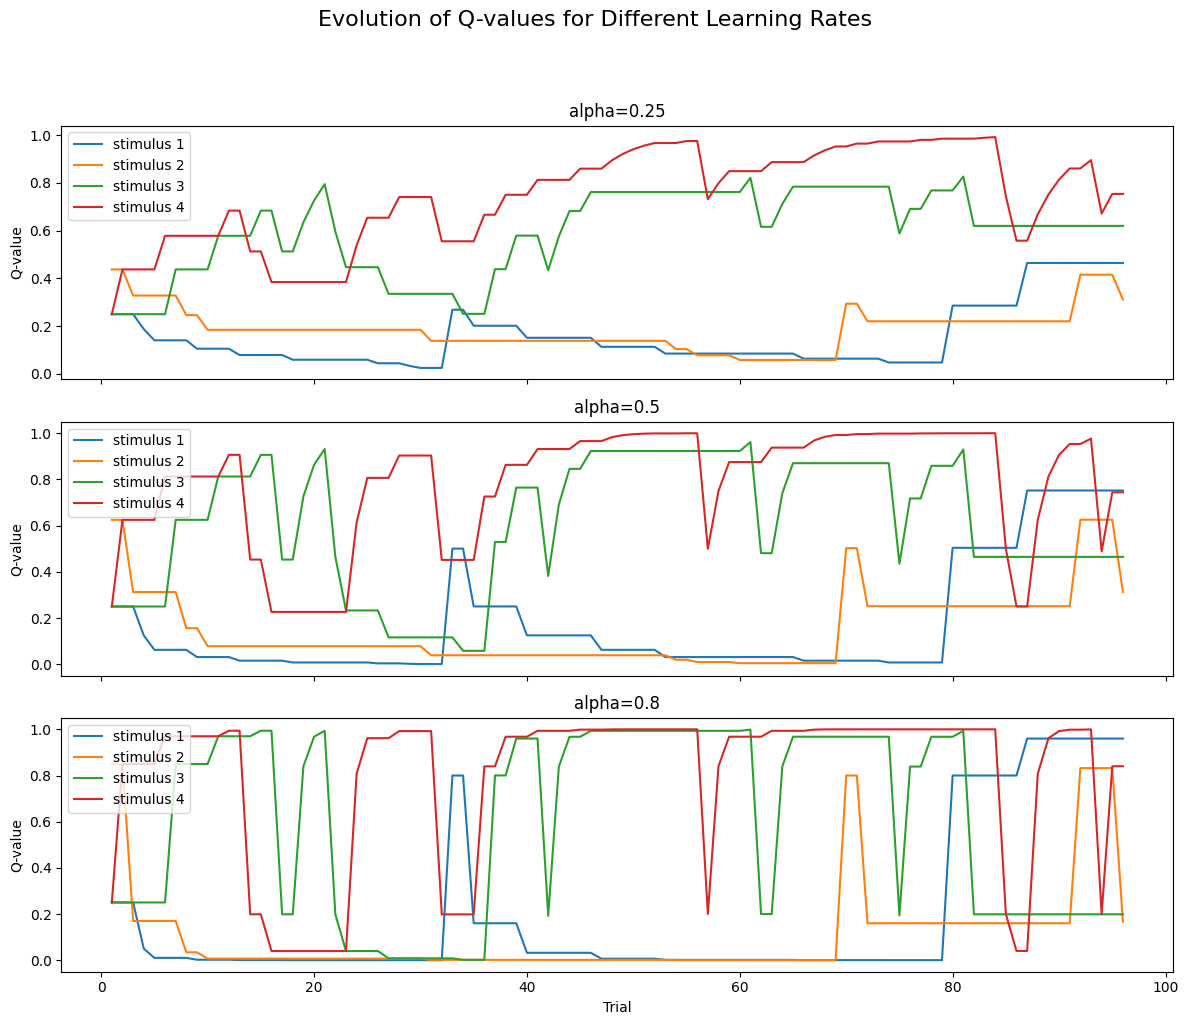

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

value_cols = ['values_0', 'values_1', 'values_2', 'values_3']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for idx, alpha in enumerate(alpha_not_so_random):
    ax = axes[idx]
    subset = big_results[big_results['alpha'] == alpha]
    for vcol, color in zip(value_cols, colors):
        ax.plot(subset['trial_0'], subset[vcol], label=vcol, color=color)
    ax.set_ylabel('Q-value')
    ax.set_title(f'alpha={alpha}')
    ax.legend(['stimulus 1', 'stimulus 2', 'stimulus 3', 'stimulus 4'], loc='upper left')
axes[-1].set_xlabel('Trial')
fig.suptitle('Evolution of Q-values for Different Learning Rates\n', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Simulating different participants with same and different parameters

There are built-in tools in the `cpm` toolbox to allow you to explore model behaviour in a variety of ways. The process of trying to understand how the model explains the data often involves exploring its parameter space, simulating different trial orders, and so on.

In [39]:
subset = data[data.ppt.isin([1, 3, 9, 4, 10])].copy()
numpy.random.seed(42)
multiple = parameters.sample(5) ## get 5 random parameter sets for each participant

simulate =  cpm.generators.Simulator(
    wrapper=wrapper,
    parameters=multiple,
    data=subset.groupby('ppt'),
)
simulate.run()
simulations_multiple_ppt = simulate.export()


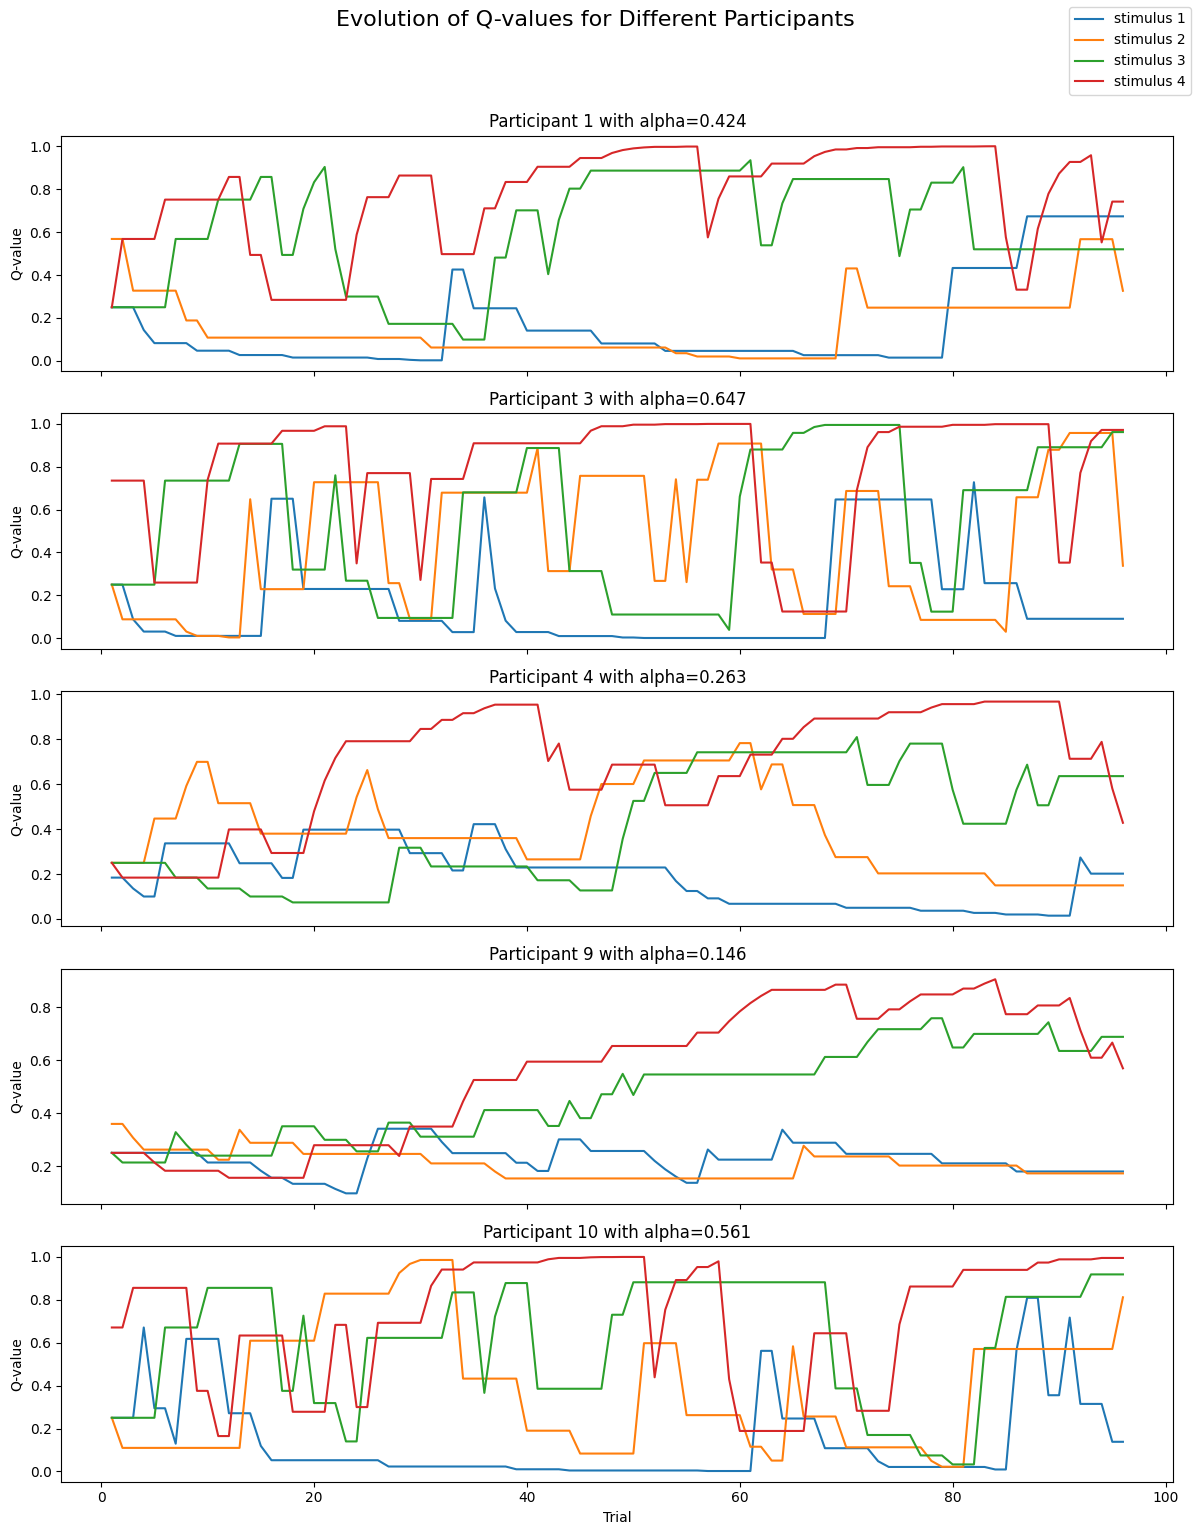

In [40]:
import matplotlib.pyplot as plt

participants = simulations_multiple_ppt['ppt'].unique()
n_participants = len(participants)

fig, axes = plt.subplots(n_participants, 1, figsize=(12, 3 * n_participants), sharex=True)

value_cols = ['values_0', 'values_1', 'values_2', 'values_3']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for idx, ppt in enumerate(participants):
    ax = axes[idx] if n_participants > 1 else axes
    subset = simulations_multiple_ppt[simulations_multiple_ppt['ppt'] == ppt]
    for vcol, color in zip(value_cols, colors):
        ax.plot(subset['trial_0'], subset[vcol], label=vcol, color=color)
    ax.set_ylabel('Q-value')
    ax.set_title(f'Participant {ppt} with alpha={numpy.round(multiple[idx].get("alpha"), 3)}')

fig.legend(['stimulus 1', 'stimulus 2', 'stimulus 3', 'stimulus 4'], loc='upper right')
axes[-1].set_xlabel('Trial')
fig.suptitle('Evolution of Q-values for Different Participants\n', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Questions to consider

* What do you notice here? What do you think about the model's behaviour?
* How do the parameters affect the model's predictions?
* How do the initial Q-values affect the model's predictions?
* Anything that surprises you?

# References

Barto AG, Sutton RS. Reinforcement learning: An introduction. 2nd ed. The MIT Press; 2018.

Bridle JS. Probabilistic interpretation of feedforward classification network outputs, with relationships to statistical pattern recognition. In: Neurocomputing: Algorithms, architectures and applications. Springer; 1990. p. 227–236.

Bush RR, Mosteller F. A mathematical model for simple learning. Psychological review. 1951;58(5):313.

Rescorla RA, Wagner AR. A theory of Pavlovian conditioning: Variations in the effectiveness of reinforcement and nonreinforcement. In: Black AH, Prokasy WF, editors. Classical Conditioning II: Current Research and Theory. Appleton-Century-Crofts; 1972. p. 64–99.

Rumelhart DE, Hinton GE, Williams RJ. Learning representations by back-propagating errors. nature. 1986;323(6088):533–536.

